----------------------------------------------------------------
## **<a class="anchor" id="link0">Problem 2: Player Categorization</a> 🎽**
----------------------------------------------------------------
**Date:** April 30, 2022</br>
**By:** Geoffrey Price</br>
</br>
In this notebook, I use cleaned data originally scraped from the AUDL website to assess the characteristics of different categories of players in the AUDL. I will use KNN and other methods to assign player positions to players who don't have a category on their website bio. 

**Problem Statement**
*How do players stats differ across different playing positions? Is there a set of stats that can be used to assign a position to players based on their performance?*</br>
The AUDL website places players into one of four categories:
- *Cutter:* A player who handles the disc less often and instead makes vertical and horizontal **cuts** on the field to help open up space or score
- *Defender:* A player who's skills are more oriented towards shutting down other teams' abilites to score
- *Handler:* A player who is skilled at identifying open players and throwing the disc to them.
- *Hybrid:* A player who has a combination of cutter and handler skills and is able to play in either position.

### Table of Contents
1. [Data Import and Overview 🧮](#link1)
2. [Univariate Analysis 1️⃣](#link2)
    - a. [Total Game Counts 🎮](#link2a)
    - b. [Goals Scored 🥅](#link2b)
    - c. [Univariate Analysis Summary](#link2c)
3. [Multivariate Analysis ✌➕](#link3)
    - a. [Correlation 📈](#link3a)
    - b. [Scores by Season 📅](#link3b)
    - c. [Margin of Victory 🤏](#link3c)
    - d. [Scoring Factor ➕➖](#link3d)
    - e. [Multivariate Analysis Summary](#link3e)
4. [Hypothesis Testing 👨🏿‍🔬](#link4)
5. [Conclusions 🔚](#link5)
    - a. [Data Limitations 📦](#link5a)
6. [Resources 🕸](#linkR)

In [137]:
# IMPORTS
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os

from icecream import ic

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import tree

%matplotlib inline

# Theme
sns.set_theme(palette='Spectral')

# Color Palette
c_palette = {
    'unknown': '#8ecae6', #light blue
    'Defender': '#219ebc', #medium blue
    'Hybrid': '#023047', #dark blue
    'Handler': '#ffb703', #gold
    'Cutter': '#fb8500' #orange
}

-------------------------------------------------------------
# <a class="anchor" id="link0">Data Import and Overview</a> 🧮
-------------------------------------------------------------

In [81]:
# Data Import
DATA_PATH = ".\\DATA\\postproc\\players.csv"
df: pd.DataFrame = pd.read_csv(DATA_PATH,)
df.head()

,player,games,points_played,off_possessions,scores,assists,goals,blocks,plus_minus,completions,...,hockey_assists,throwaways,stalls,drops,callahans,pulls,off_points_played,def_points_played,minutes_played,position
0,Cameron Brock,122,2631,2838,756,240,516,49,585,1644,...,146,177,0,43,0,6,2204,427,2123,Cutter
1,Cameron Harris,108,2361,2734,610,337,273,115,488,2035,...,180,198,1,39,0,132,1756,605,2117,Hybrid
2,Ben Jagt,79,1995,2194,525,254,271,115,485,1231,...,121,122,2,33,1,114,1202,793,2000,Hybrid
3,Jonathan Helton,110,2550,2288,609,362,247,147,458,2312,...,152,255,3,43,0,452,1738,812,1886,Hybrid
4,Keenan Plew,115,2429,2656,644,358,286,32,456,3584,...,213,179,1,41,1,5,2076,353,2022,Hybrid


In [82]:
# Dtypes and info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2558 entries, 0 to 2557
Data columns (total 25 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   player             2558 non-null   object 
 1   games              2558 non-null   int64  
 2   points_played      2558 non-null   int64  
 3   off_possessions    2558 non-null   int64  
 4   scores             2558 non-null   int64  
 5   assists            2558 non-null   int64  
 6   goals              2558 non-null   int64  
 7   blocks             2558 non-null   int64  
 8   plus_minus         2558 non-null   int64  
 9   completions        2558 non-null   int64  
 10  completion_pct     1317 non-null   float64
 11  total_yards        2558 non-null   int64  
 12  throwing_yards     2558 non-null   int64  
 13  receiving_yards    2558 non-null   int64  
 14  off_efficiency     1574 non-null   float64
 15  hockey_assists     2558 non-null   int64  
 16  throwaways         2558 

### Summary:
- All category dtypes are correct. The only two 'object' categories are the player names and positions.
- `completion_pct`, `off_efficiency`, and `position` are the only three columns with null data.

----------------
# <a class="anchor" id="link2">Univariate Analysis 1️⃣</a>
----------------

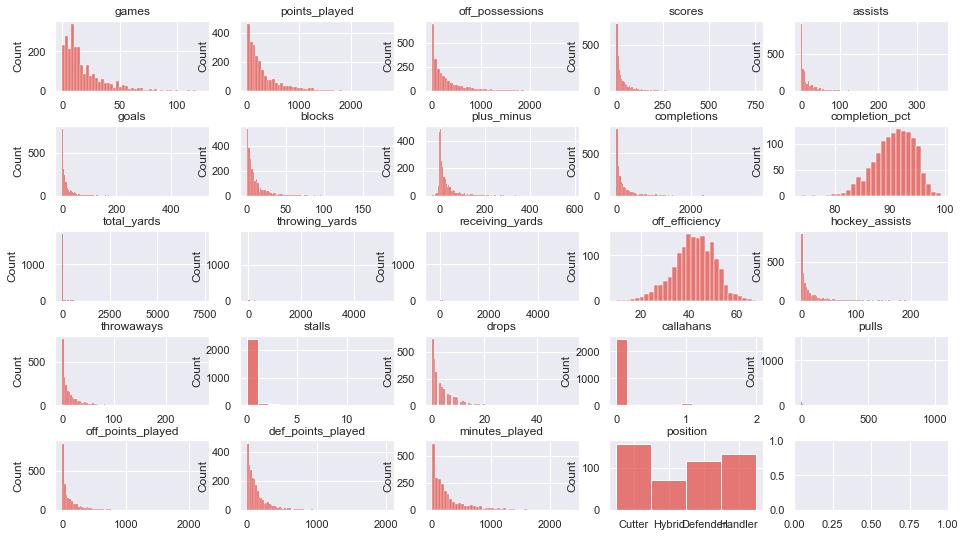

In [83]:
fig, ax = plt.subplots(nrows=5, ncols=5, figsize=(16, 9))
plt.subplots_adjust(hspace=0.5)

for col, ax in zip(df.columns.drop('player'), ax.ravel()):
    sns.histplot(data=df, x=col, ax=ax)

    # chart formatting
    ax.set_title(col)
    # ax.get_legend().remove()
    ax.set_xlabel("")

### Notes:
- Majority of distributions are heavily right skewed.
- The two distributions measuring efficiency (`off_efficiency` and `completion_pct`) are more normally distributed with some left skew
- Many stats have a very small number of players who have the highest categories
- Given `games` and `points_played` follow similar distributions, for this analysis the majority of attributes will be normalized by `points_played`.

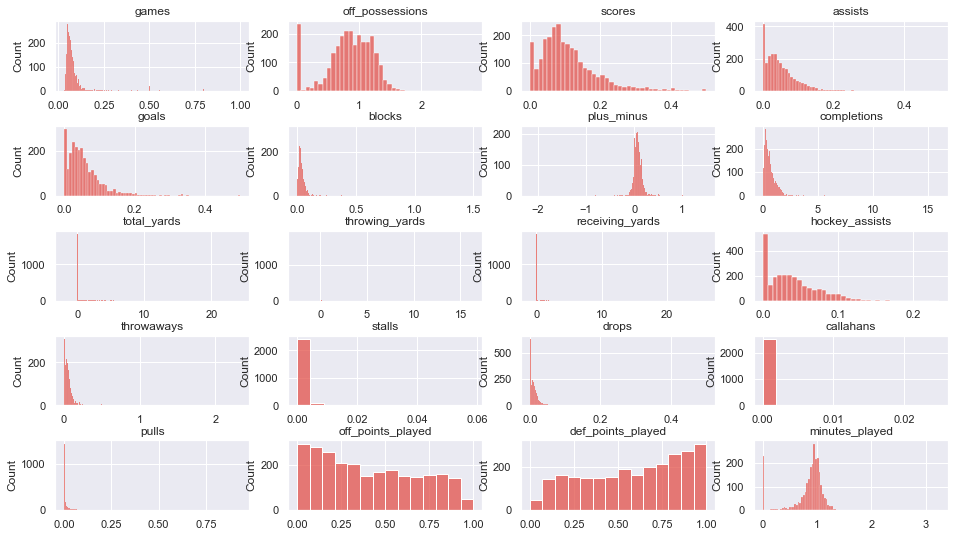

In [84]:
cols_to_ignore = ['completion_pct', 'off_efficiency', 'position', 'player']
cols_to_keep = df.columns.drop(labels=cols_to_ignore)

# Normalize by points played
norm_df = df.loc[:, cols_to_keep].div(df['points_played'], axis=0)

fig, ax = plt.subplots(nrows=5, ncols=4, figsize=(16, 9))
plt.subplots_adjust(hspace=0.5)

for col, ax in zip(norm_df.columns.drop(labels=['points_played']), ax.ravel()):
    sns.histplot(data=norm_df, x=col, ax=ax)

    # chart formatting
    ax.set_title(col)
    ax.set_xlabel("")


By normalizing by points played, the stats shown are more indicative of skill level when compared to other values. More points played = more opportunity and, without normalizing, players who've played more games/points will appear to be better in comparison to others who have not.

There are a lot of stats that show a high value count of '0' for that stat. This could be a select set of players who don't have very high stats. The subset of players  with 0 completions is analyzed below.

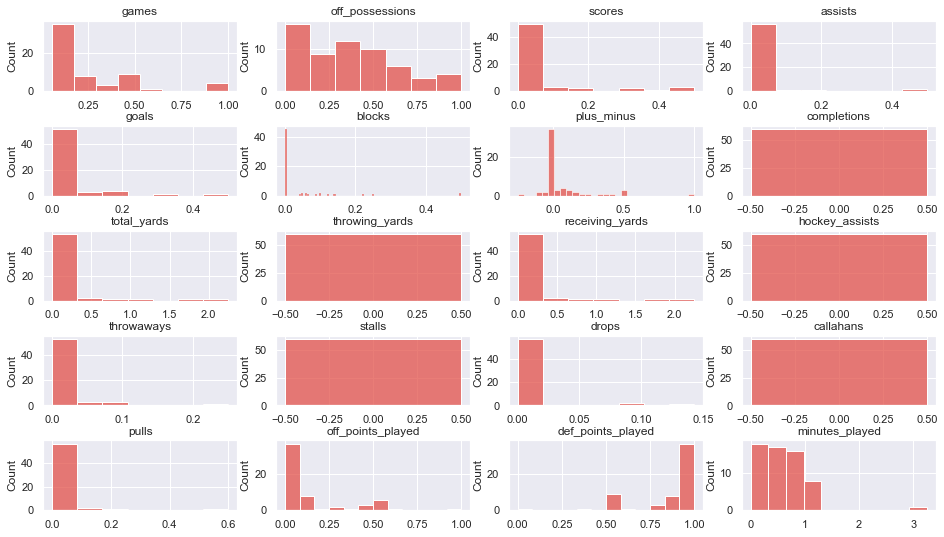

In [85]:
zero_comp = norm_df[norm_df['completions'] == 0]

fig, ax = plt.subplots(nrows=5, ncols=4, figsize=(16, 9))
plt.subplots_adjust(hspace=0.5)

for col, ax in zip(zero_comp.columns.drop(labels=['points_played']), ax.ravel()):
    sns.histplot(data=zero_comp, x=col, ax=ax)

    # chart formatting
    ax.set_title(col)
    ax.set_xlabel("")

There are 60 players who are noted as having no completions. This is suspicious because it's almost impossible to play multiple points in ultimate and not throw the disc to someone else for a single completion.

These 60 players account for 7 labeled players:
- 3 cutters
- 2 handlers
- 1 defender, and
- 1 hybrid

For now, all 60 entries will be kept in the data set.

-------------------------------
# <a class="anchor" id="link3">Multivariate Analysis ✌🏿➕</a>
-------------------------------

## Correlation Heatmap

In [86]:
# Change name of norm_df to df and add position
full_df = df
df = norm_df
df['position'] = full_df['position']

# Add 'unknown' to position
df['position'] = df['position'].fillna('unknown')


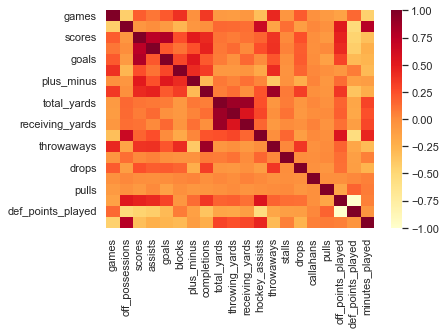

In [87]:
# Correlation Matrix
corr_df = df.drop(labels='points_played', axis=1).corr()
sns.heatmap(corr_df, cmap='YlOrRd');

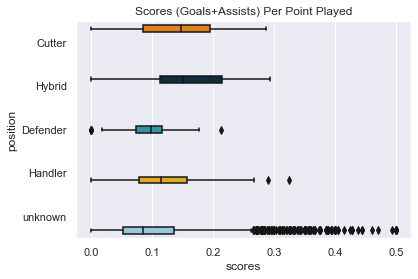

In [88]:
sns.boxplot(data=df, x='scores', y='position', hue='position', palette=c_palette)
plt.title('Scores (Goals+Assists) Per Point Played')
plt.legend().remove()

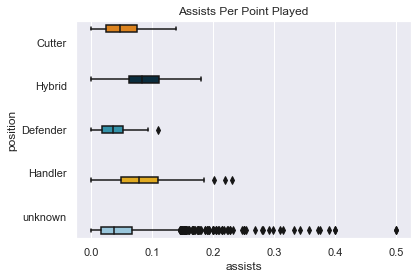

In [89]:
sns.boxplot(data=df, x='assists', y='position', hue='position', palette=c_palette)
plt.title('Assists Per Point Played')
plt.legend().remove()

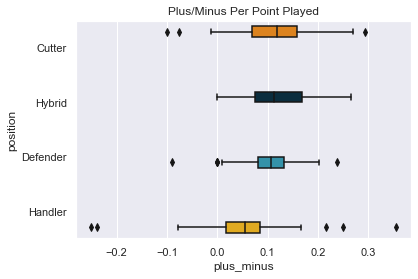

In [90]:
# Plus/Minus - 'Unknown' category removed due to high number of outliers
sns.boxplot(data=df[df['position'] != 'unknown'], 
            x='plus_minus', y='position', 
            hue='position', palette=c_palette)
plt.title('Plus/Minus Per Point Played')
plt.legend().remove()

In [92]:
# Pairplot 
# sns.pairplot(data=df[df['position'] != 'unknown'], hue='position', palette=c_palette, corner=True);

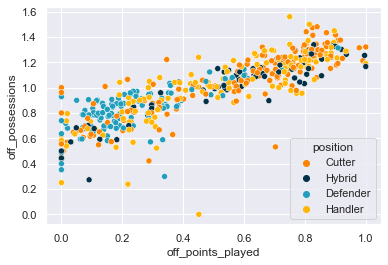

In [93]:
sns.scatterplot(data=df[df['position'] != 'unknown'], 
                x='off_points_played', 
                y='off_possessions', 
                hue='position',
                palette=c_palette);

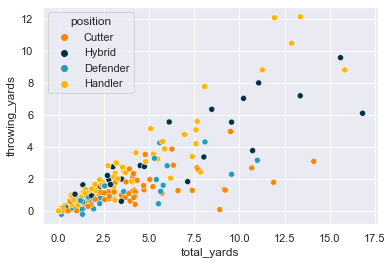

In [94]:
sns.scatterplot(data=df[df['position'] != 'unknown'], 
                x='total_yards', 
                y='throwing_yards', 
                hue='position',
                palette=c_palette);

### Notes
- High correlation between throwing_yards, total_yards, and receiving_yards
- High correlation between completions and throwaways
- High correlation between offensive possesions, hockey_assists, and minutes_played

Given several areas of high correlation, it is in good interest to remove several columns before performing linear regression.

- The shown pairplot indicates good segmentation between certain classes like handler and cutter. The 'unknown' category is not included because the majority of players are 'unknown' and it makes it more difficult to see patterns among the already labeled data points.
- Although there is some existing division among players, the differences among the player categories is not fully apparent.

In the next section, the following steps are taken to further prepare the data for various forms of supervised learning.
- Principle Component Analysis (PCA) with and without a standard scaler

-----------------------
# PCA
-----------------------

In [95]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [96]:
# Drop Null Row
df[df.isna().any(axis=1)]
df.drop(labels=2161, axis=0, inplace=True)

In [97]:
df[['games','points_played', 'off_possessions', 'scores', 'assists','total_yards']].sample(5, random_state=92)

,games,points_played,off_possessions,scores,assists,total_yards
2004,0.103448,1.0,0.793103,0.000000,0.000000,0.0
278,0.045673,1.0,1.250000,0.180288,0.057692,0.0
409,0.043103,1.0,1.209052,0.148707,0.062500,0.0
1835,0.084507,1.0,1.239437,0.084507,0.056338,0.0
689,0.069853,1.0,0.819853,0.044118,0.003676,0.0


In [98]:
# Scale and repeat Sample
temp = df.drop(labels='position', axis=1).copy(deep=True)
scaler: StandardScaler = StandardScaler()
scaler.fit(temp)
scaled_array = scaler.transform(temp)

In [99]:
scaled_df = pd.DataFrame(scaled_array, columns=[i for i in df.columns if i != 'position'])
scaled_df[['games','points_played', 'off_possessions', 'scores', 'assists','total_yards']].sample(5, random_state=92)

,games,points_played,off_possessions,scores,assists,total_yards
2004,0.199184,0.0,-0.111178,-1.332878,-1.019393,-0.394082
278,-0.449336,0.0,1.093204,0.857273,0.127625,-0.394082
409,-0.478179,0.0,0.985264,0.473619,0.223210,-0.394082
1835,-0.013429,0.0,1.065359,-0.306283,0.100700,-0.394082
689,-0.177919,0.0,-0.040667,-0.796935,-0.946299,-0.394082


In [100]:

scaled_pca = PCA(n_components=2)
scaled_pca.fit(scaled_df)
scaled_x_pca = scaled_pca.transform(scaled_df)

raw_df = df.drop(labels='position', axis=1).copy(deep=True)
raw_pca = PCA(n_components=2)
raw_pca.fit(raw_df)
raw_x_pca = raw_pca.transform(raw_df)

In [101]:
print(f"The explained variance ratios using raw data is {raw_pca.explained_variance_ratio_}")
print(f"The explained variance ratios using scaled data is {scaled_pca.explained_variance_ratio_}")

The explained variance ratios using raw data is [0.84536627 0.08234642]
The explained variance ratios using scaled data is [0.21326006 0.19356994]


In [102]:
raw_x_pca_labeled = pd.DataFrame(raw_x_pca, columns=['rx1','rx2'])
raw_x_pca_labeled = raw_x_pca_labeled.merge(right=df['position'], how='left', left_index=True, right_index=True)
raw_x_pca_labeled

,rx1,rx2,position
0,-0.469572,0.050592,Cutter
1,1.077120,-0.332411,Hybrid
2,3.058701,1.166369,Hybrid
3,0.917934,-0.310852,Hybrid
4,-1.322156,-0.254209,Hybrid
...,...,...,...
2552,-1.309000,-0.223904,unknown
2553,-1.311201,-0.287924,unknown
2554,-1.323835,-0.207992,unknown
2555,4.774033,-3.446430,unknown


In [103]:
scaled_x_pca_labeled = pd.DataFrame(scaled_x_pca, columns=['x1','x2'])
scaled_x_pca_labeled = scaled_x_pca_labeled.merge(right=df['position'], how='left', left_index=True, right_index=True)
scaled_x_pca_labeled

,x1,x2,position
0,3.239731,-0.209619,Cutter
1,3.267564,-0.784639,Hybrid
2,2.861570,-1.001201,Hybrid
3,2.702127,-0.095684,Hybrid
4,3.616364,-0.405847,Hybrid
...,...,...,...
2552,1.466241,-1.843755,unknown
2553,0.890488,-1.562325,unknown
2554,0.943657,-0.766662,unknown
2555,2.049285,-2.638832,unknown


Text(0.5, 1.0, 'Raw PCA (n=2)')

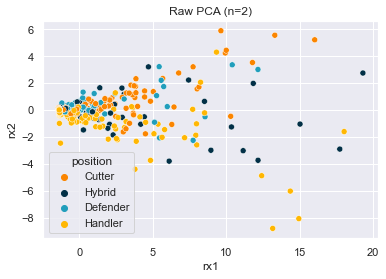

In [104]:
sns.scatterplot(data=raw_x_pca_labeled[raw_x_pca_labeled['position'] != 'unknown'], x='rx1', y='rx2', hue='position', palette=c_palette)
plt.title('Raw PCA (n=2)')

Text(0.5, 1.0, 'Scaled Data PCA (n=2)')

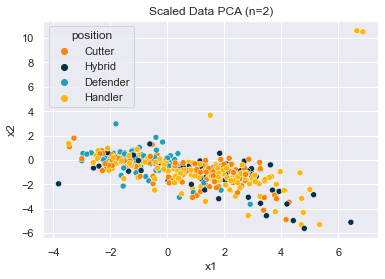

In [105]:
sns.scatterplot(data=scaled_x_pca_labeled[scaled_x_pca_labeled['position'] != 'unknown'], x='x1', y='x2', hue='position', palette=c_palette)
plt.title('Scaled Data PCA (n=2)')

*NOTES:*
- 
- 
- 


---------------------------
# <a class="anchor" id="linkLR">K Means and KNN</a>
---------------------------

In [167]:
# IMPORTS
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors, NeighborhoodComponentsAnalysis, KNeighborsClassifier
from sklearn.pipeline import Pipeline

In [107]:
# Data Prep
unknown_idx = df[df['position'] == 'unknown'].index

scaled_df.drop(labels='points_played', axis=1, inplace=True)
df.drop(labels=['points_played', 'position'], axis=1, inplace=True)

scaled_df.drop(labels=unknown_idx, inplace=True, axis=0)
df.drop(labels=unknown_idx, inplace=True, axis=0)

# KMeans
scaled_kmeans = KMeans(n_clusters=4, random_state=92).fit(scaled_df)
raw_kmeans = KMeans(n_clusters=4, random_state=92).fit(df)

In [118]:
print("SCALED KMEANS")
for i in range(4):
    print(f"LABEL: {i} -- COUNT: {list(scaled_kmeans.labels_).count(i)}")

print("*"*20)

print("RAW KMEANS")
for i in range(4):
    print(f"LABEL: {i} -- COUNT: {list(raw_kmeans.labels_).count(i)}")

SCALED KMEANS
LABEL: 0 -- COUNT: 47
LABEL: 1 -- COUNT: 221
LABEL: 2 -- COUNT: 2
LABEL: 3 -- COUNT: 204
********************
RAW KMEANS
LABEL: 0 -- COUNT: 349
LABEL: 1 -- COUNT: 12
LABEL: 2 -- COUNT: 23
LABEL: 3 -- COUNT: 90


In [124]:
df['_km_labels'] = scaled_kmeans.labels_

In [125]:
df['position'] = full_df['position']

# Add 'unknown' to position
df['position'] = df['position'].fillna('unknown')

In [129]:
for i in range(4):
    print(f"Label: {i}")

    for p in ['Cutter', 'Handler', 'Defender', 'Hybrid']:
        temp = df[(df['position'] == p) & (df['_km_labels'] == i)]
        total = len(df[df['position'] == p])
        print(f"\t -{p}: {round(100*len(temp)/total,2)}%")

Label: 0
	 -Cutter: 10.9%
	 -Handler: 10.61%
	 -Defender: 4.31%
	 -Hybrid: 15.71%
Label: 1
	 -Cutter: 35.26%
	 -Handler: 34.85%
	 -Defender: 90.52%
	 -Hybrid: 21.43%
Label: 2
	 -Cutter: 0.0%
	 -Handler: 1.52%
	 -Defender: 0.0%
	 -Hybrid: 0.0%
Label: 3
	 -Cutter: 53.85%
	 -Handler: 53.03%
	 -Defender: 5.17%
	 -Hybrid: 62.86%


- In both cases (raw data v. scaled), the classes are highly imbalanced and are likely not very indicative of actual differentiations between players. The scaled k-means fit is slightly less imbalanced with two primary clusters arising. 

- Defenders appear to be easily identifiable based on stats. Over 90% of defenders (105/116) were placed under Label #1. This category is not a 'catch all' category because the majority of players from all other categories are under Label # 3. The results indicate that differentiation defenders is easier based on the provided stats, but separating handlers, cutters, and hybrid players may be more difficult.

- Given the two examples above, the raw data performs better when clustering. This will be the data set used moving forward.

------------------------------
# Training and Testing Data
------------------------------

In [151]:
y = df['position'].astype('category').cat.codes
X = df.copy(deep=True)

X.drop(labels=['_km_labels'], axis=1, inplace=True)
X['position'] = X['position'].astype('category').cat.codes

y = X['position']
X.drop(labels='position', inplace=True, axis=1)

In [154]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=92, stratify=y)

-----------------------------
# KNN
-----------------------------

c:\Users\Geoffrey\Documents\GitHub\audl_ds\.venv3.9.4\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

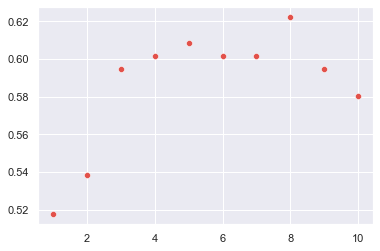

In [176]:
n = 10
score = []
for i in range(1,n+1):
    neighbors = KNeighborsClassifier(n_neighbors=i)
    nca = NeighborhoodComponentsAnalysis(random_state=92)

    nca_pipe = Pipeline([('nca', nca), ('knn', neighbors)])
    nca_pipe = nca_pipe.fit(X_train, y_train)
    score.append(nca_pipe.score(X_test, y_test))

sns.scatterplot([i for i in range(1, n+1)], score)

- In a KNN Classifier, the optimal number of neighbors appears to be 8 when looking at k<=10

--------------------------
# Random Forest
--------------------------

In [179]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
from sklearn import metrics
from sklearn import tree
from sklearn.model_selection import GridSearchCV

In [181]:
dt_model = DecisionTreeClassifier(criterion='gini', random_state=92)
dt_model.fit(X_train, y_train)

DecisionTreeClassifier(random_state=92)

In [182]:
# accuracy on training set
print("Accuracy on train set", dt_model.score(X_train, y_train))

# accuracy on test set
print("Accuracy on test set", dt_model.score(X_test, y_test))

Accuracy on train set 1.0
Accuracy on test set 0.5314685314685315


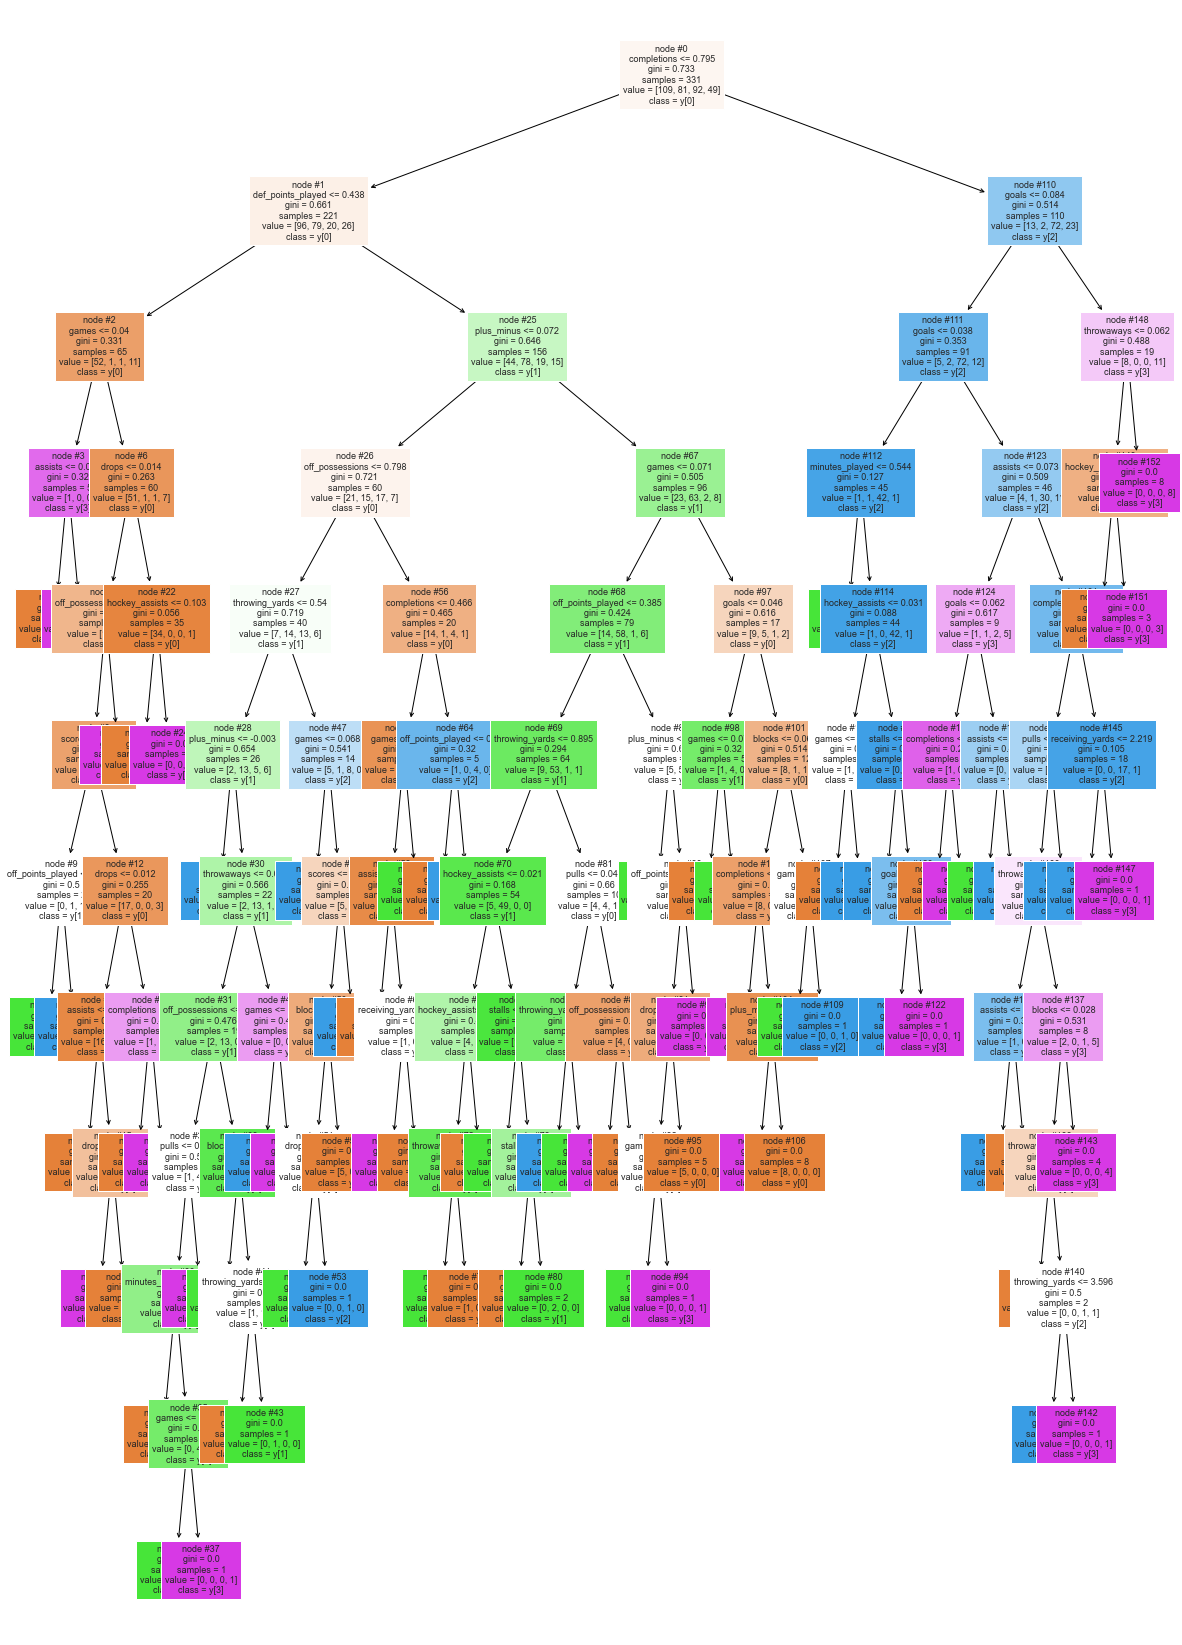

In [183]:
feature_names = list(X_train.columns)
plt.figure(figsize=(20,30))

out = tree.plot_tree(dt_model,feature_names=feature_names,filled=True,fontsize=9,node_ids=True,class_names=True)
for o in out:
     arrow = o.arrow_patch
     if arrow is not None:
        arrow.set_edgecolor('black')
        arrow.set_linewidth(1)
plt.show()

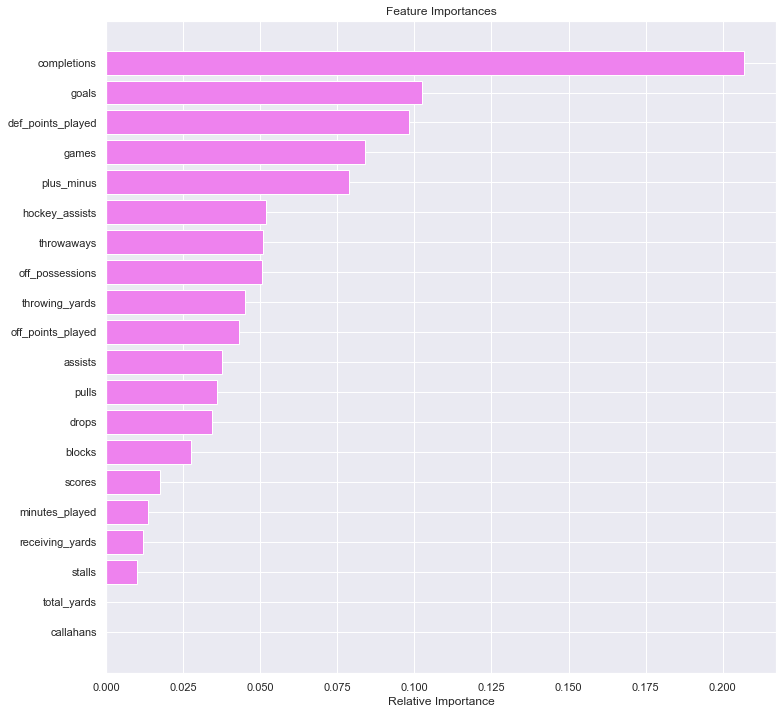

In [185]:
importances = dt_model.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(12,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='violet', align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [186]:
# Choose the type of classifier. 
estimator = DecisionTreeClassifier(random_state=92)

# Grid of parameters to choose from

parameters = {'max_depth': np.arange(1,10), 
              'min_samples_leaf': [1, 2, 5, 7, 10,15,20],
              'max_leaf_nodes' : [5, 10,15,20,25,30],
              'min_impurity_decrease': [0.0001,0.001,0.01,0.1]
             }

# Type of scoring used to compare parameter combinations
acc_scorer = metrics.make_scorer(metrics.recall_score)

# Run the grid search
grid_obj = GridSearchCV(estimator, parameters, scoring=acc_scorer,cv=5)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
estimator = grid_obj.best_estimator_

# Fit the best algorithm to the data. 
estimator.fit(X_train, y_train)

NameError: name 'xtrain' is not defined

---------------------------
# <a class="anchor" id="linkR">Resources 🕸</a>
---------------------------
1. [The AUDL Website](https://theaudl.com/)
2. ['AUDL 2019: Closer than Ever'](https://theaudl.com/league/news/2019-audl-closer-ever-competition)
3. ['AUDL Announces 2022 Schedule, Championship Weekend Back in Madison](https://ultiworld.com/2022/02/21/audl-announces-2022-schedule-championship-weekend-back-in-madison/#:~:text=Along%20with%20the%20return%20of,Lake%20Shred%2C%20and%20Colorado%20Summit)

### DATA NOTES:
- It's very possible for players to switch positions as they progress. Unfortunately the labeled data for players is not by season. If a player switches from cutter to handler, and they are labeled as a handler, their stats likely aren't fully indicative of a typical handler's stats.
- Assumption: The labeled players are a good representation of a random selection of players with significant playtime from the league.
- The quantity and quality of data collected has improved significantly as the AUDL has had more and more seasons.